In [1]:
# Célula 1: Instalação de Dependências
# Instalação das bibliotecas necessárias
!pip install facenet-pytorch gdown

In [2]:
# Célula 2: Importações e Configuração
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import gdown

# Configuração do dispositivo (GPU se disponível, caso contrário CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Rodando em: {device}')

Rodando em: cuda:0


In [3]:
# Célula 3: Download dos Dados
# IDs dos arquivos no Google Drive
dataset_id = '1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT'  # Dataset Celebridades
person_1_id = '1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb' # Pessoa (Cadastro 1)
# O enunciado repetiu o link para cadastro 2 e máscara,
# vamos baixar como arquivos distintos para tratar a lógica corretamente.
person_mask_id = '1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW' # Pessoa (Máscara / Cadastro 2)

# Função para baixar e extrair
def download_and_extract(file_id, output_name, is_zip=False):
    if not os.path.exists(output_name):
        print(f'Baixando {output_name}...')
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, output_name, quiet=False)

        if is_zip:
            print(f'Extraindo {output_name}...')
            with zipfile.ZipFile(output_name, 'r') as zip_ref:
                zip_ref.extractall('./dataset_celebs')
    else:
        print(f'{output_name} já existe.')

# 1. Baixar Dataset
download_and_extract(dataset_id, 'celebridades.zip', is_zip=True)

# 2. Baixar Fotos da Pessoa Alvo
# Criamos uma pasta para organizar
os.makedirs('target_person', exist_ok=True)
download_and_extract(person_1_id, 'target_person/foto_clara_1.jpg')
download_and_extract(person_mask_id, 'target_person/foto_mascara.jpg')

print("Downloads concluídos.")

Baixando celebridades.zip...


Downloading...
From (original): https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT
From (redirected): https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT&confirm=t&uuid=e6cf8bb3-a780-444a-b068-72bb60fe7536
To: /content/celebridades.zip
100%|██████████| 71.4M/71.4M [00:01<00:00, 59.5MB/s]


Extraindo celebridades.zip...
Baixando target_person/foto_clara_1.jpg...


Downloading...
From: https://drive.google.com/uc?id=1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb
To: /content/target_person/foto_clara_1.jpg
100%|██████████| 37.5k/37.5k [00:00<00:00, 17.3MB/s]


Baixando target_person/foto_mascara.jpg...


Downloading...
From: https://drive.google.com/uc?id=1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW
To: /content/target_person/foto_mascara.jpg
100%|██████████| 87.6k/87.6k [00:00<00:00, 2.87MB/s]

Downloads concluídos.


In [4]:
# Célula 4: Inicialização dos Modelos
# 1. MTCNN: Detector de Faces
# keep_all=False: Queremos apenas o rosto principal (maior probabilidade)
# margin=20: Adiciona uma margem ao redor do rosto para incluir contexto (ajuda na máscara)
mtcnn = MTCNN(
    image_size=160, margin=20, keep_all=False, select_largest=True, post_process=False, device=device
)

# 2. InceptionResnetV1: Extrator de Características (Embeddings)
# Pretrained='vggface2': Treinado em um dataset massivo de rostos
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

print("Modelos carregados com sucesso.")

  0%|          | 0.00/107M [00:00<?, ?B/s]

Modelos carregados com sucesso.


In [5]:
# Célula 5: Função Auxiliar para Gerar Embeddings
def get_embedding(image_path, model, detector):
    """
    Lê uma imagem, detecta a face e retorna o embedding (vetor de características).
    """
    try:
        img = Image.open(image_path)
        # Converter para RGB se for P&B ou tiver canal Alpha
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Detecta e recorta o rosto (retorna um tensor já normalizado)
        face_tensor = detector(img)

        if face_tensor is not None:
            # Envia para GPU/CPU e adiciona dimensão do batch (1, 3, 160, 160)
            face_tensor = face_tensor.unsqueeze(0).to(device)

            # Gera o embedding (sem calcular gradientes pois não estamos treinando)
            with torch.no_grad():
                embedding = model(face_tensor)

            # Retorna como numpy array na CPU (vetor de 512 dimensões)
            return embedding.detach().cpu().numpy()[0]
        else:
            print(f"Rosto não detectado em: {image_path}")
            return None
    except Exception as e:
        print(f"Erro ao processar {image_path}: {e}")
        return None

In [6]:
# Célula 6: Construção do Banco de Dados (Celebridades + Pessoa Alvo)
# Dicionário para armazenar o banco de dados
# Formato: {'Nome_da_Pessoa': embedding_vector}
face_db = {}

# 1. Processar Celebridades (Dataset baixado)
# Ajuste o caminho abaixo conforme a estrutura extraída do ZIP
dataset_path = './dataset_celebs'

# Varre pastas e arquivos
print("Criando banco de dados...")
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(root, file)
            # O nome da pessoa será o nome da pasta ou do arquivo
            name = os.path.basename(root) # Assume estrutura dataset/Nome/foto.jpg
            if name == 'dataset_celebs': name = os.path.splitext(file)[0]

            emb = get_embedding(path, resnet, mtcnn)
            if emb is not None:
                face_db[name] = emb
                print(f"Adicionado: {name}")

# 2. Incluir a Pessoa Alvo (Foto sem máscara)
# Vamos usar a foto clara para cadastrar
target_name = "Pessoa_Alvo"
target_path = 'target_person/foto_clara_1.jpg'

emb_target = get_embedding(target_path, resnet, mtcnn)

if emb_target is not None:
    face_db[target_name] = emb_target
    print(f"Adicionado NOVA PESSOA: {target_name}")
else:
    print("Falha ao cadastrar a Pessoa Alvo (rosto não detectado na foto clara).")

print(f"Total de pessoas no banco de dados: {len(face_db)}")

A saída de streaming foi truncada nas últimas 5000 linhas.
Adicionado: Jeane_Kirkpatrick
Adicionado: Chris_Neil
Adicionado: Chris_Neil
Adicionado: Chris_Neil
Adicionado: Chris_Neil
Adicionado: Dinah_Turner
Adicionado: Dinah_Turner
Adicionado: Dinah_Turner
Adicionado: Dinah_Turner
Adicionado: Dinah_Turner
Adicionado: Juan_Roman_Riquelme
Adicionado: Juan_Roman_Riquelme
Adicionado: Juan_Roman_Riquelme
Adicionado: Juan_Roman_Riquelme
Adicionado: Juan_Roman_Riquelme
Adicionado: Craig_Fitzgibbon
Adicionado: Craig_Fitzgibbon
Adicionado: Morgan_Freeman
Adicionado: Morgan_Freeman
Adicionado: Morgan_Freeman
Adicionado: Morgan_Freeman
Adicionado: Morgan_Freeman
Adicionado: Elizabeth_Taylor
Adicionado: Elizabeth_Taylor
Adicionado: Elizabeth_Taylor
Adicionado: Sheila_Wellstone
Adicionado: Sheila_Wellstone
Adicionado: Jean-Francois_Pontal
Adicionado: Jean-Francois_Pontal
Adicionado: Jean-Francois_Pontal
Adicionado: AJ_Lamas
Adicionado: AJ_Lamas
Adicionado: Hugo_Colace
Adicionado: Hugo_Colace
Adicion

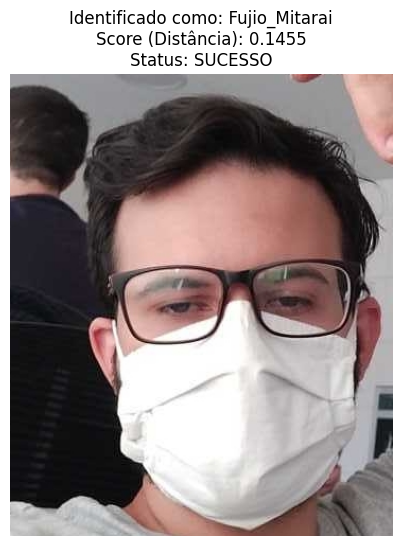

Resultado Final:
A imagem de máscara foi identificada como: Fujio_Mitarai
Métrica de Distância (Menor é melhor): 0.1454652100801468


In [7]:
# Célula 7: Reconhecimento Facial (Inferência na Foto com Máscara)
def recognize_face(image_path, db, model, detector):
    # 1. Gerar embedding da imagem de teste
    test_emb = get_embedding(image_path, model, detector)

    if test_emb is None:
        return "Rosto não detectado", 0.0

    min_dist = float('inf')
    identified_name = "Desconhecido"

    # 2. Comparar com todos no banco de dados
    for name, db_emb in db.items():
        # Distância Euclidiana (L2)
        dist = np.linalg.norm(test_emb - db_emb)

        if dist < min_dist:
            min_dist = dist
            identified_name = name

    return identified_name, min_dist

# --- Execução do Teste ---
test_image_path = 'target_person/foto_mascara.jpg'

# Realiza o reconhecimento
name_found, score = recognize_face(test_image_path, face_db, resnet, mtcnn)

# --- Exibição dos Resultados (Obrigatório) ---
img = Image.open(test_image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')

# Definir um Threshold (limite) visual
# Geralmente, distancias < 0.8 ou 0.9 indicam a mesma pessoa para este modelo
threshold = 0.9
status = "SUCESSO" if score < threshold else "INCERTO/DESCONHECIDO"

plt.title(f"Identificado como: {name_found}\nScore (Distância): {score:.4f}\nStatus: {status}")
plt.show()

print(f"Resultado Final:")
print(f"A imagem de máscara foi identificada como: {name_found}")
print(f"Métrica de Distância (Menor é melhor): {score}")